#Recognizing different cricket swings with Keras LeNet-5 CNN

In [ ]:
#Barlomiej Karas 19235305, Adam O'Sullivan 19265808
# Excecutes to end without error
# Dataset from here: https://www.kaggle.com/datasets/aneesh10/cricket-shot-dataset

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import os
import cv2
import tensorflow as tf
from tensorflow import keras
from keras.layers import Conv2D, AveragePooling2D, Flatten, Dense, Dropout
from keras.models import Sequential
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.model_selection import KFold, StratifiedKFold

In [ ]:
from google.colab import drive
drive.mount('/content/drive') #mounts the specified google drive folder

Mounted at /content/drive


In [ ]:
!unzip "/content/drive/MyDrive/archive.zip" #unzips the data from the specified folder

Archive:  /content/drive/MyDrive/archive.zip
  inflating: data/drive/drives1.png  
  inflating: data/drive/drives10.png  
  inflating: data/drive/drives100.png  
  inflating: data/drive/drives1000.png  
  inflating: data/drive/drives1001.png  
  inflating: data/drive/drives1002.jpeg  
  inflating: data/drive/drives1003.png  
  inflating: data/drive/drives1004.png  
  inflating: data/drive/drives1005.png  
  inflating: data/drive/drives1006.png  
  inflating: data/drive/drives1007.png  
  inflating: data/drive/drives1008.jpeg  
  inflating: data/drive/drives1009.png  
  inflating: data/drive/drives101.png  
  inflating: data/drive/drives1010.png  
  inflating: data/drive/drives1011.png  
  inflating: data/drive/drives1012.png  
  inflating: data/drive/drives1013.png  
  inflating: data/drive/drives1014.jpeg  
  inflating: data/drive/drives1015.png  
  inflating: data/drive/drives1016.png  
  inflating: data/drive/drives1017.png  
  inflating: data/drive/drives1018.png  
  inflating: dat

In [ ]:
CATEGORIES = ["drive", "legglance-flick", "pullshot", "sweep"]

In [ ]:
training_data = []
IMG_SIZE = 32

for category in CATEGORIES: #Loops through each category
  path = "/content/data/" + category #Gets the path of the current category
  class_num = CATEGORIES.index(category) #getting the class number which will serve as a label
  for img in os.listdir(path): #Loops through each image in the current category's folder
    try:
      img_array = cv2.imread(os.path.join(path,img), cv2.IMREAD_GRAYSCALE) #creates an array of a grayscale version of the current image
      new_array = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE)) #resizes the image to be 32*32
      training_data.append([new_array, class_num]) #appends the image data and the class number
    except Exception as e:
      pass #if there is an issue loading the image it essentially gets skipped here

import random
random.shuffle(training_data) #shuffles the data to add a little bit of pseudo-randomness

In [ ]:
#Initialize empty training and test arrays
train_x = []
train_y = []
test_x = []
test_y = []


In [ ]:
for feature, label in training_data: #looping through the training data and splitting it into two arrays, one with the image data and one with the class number
  train_x.append(feature)
  train_y.append(label)

#popping 20% of the training data off which will serve as our test data
test_x = [train_x.pop(j) for j in range(int((len(train_x)*0.2)))]
test_y = [train_y.pop(k) for k in range(int((len(train_y)*0.2)))]

#converting the arrays into numpy arrays and then essentially reshaping the images to be 32*32
train_x = np.array(train_x).reshape(-1, IMG_SIZE, IMG_SIZE, 1)
test_x = np.array(test_x).reshape(-1, IMG_SIZE, IMG_SIZE, 1)
test_y = np.array(test_y)
train_y = np.array(train_y)

In [ ]:
#Here we normalize the training and test data
train_x = train_x/255
test_x = test_x/255

In [ ]:
def create_model():
  #we begin by initialising a sequential model
  # The first layer we add is a convolution layer. The parameters for this are as follows:
  # - number of filters: 6
  # - a 2-tuple which specifies the width and height of the window: kernel_size=5
  # - specifies the strides of the convolution along the height and width: strides=1
  # - an activation function which in this case is relu: activation='relu'
  # - this is only necessary for the first layer of the MLP
  #   as it sets the starting tensor. it must be the same
  #   shape as the training data. an input shape which essentially sets the starting tensor: input_shape=train_x[0].shape
  # Then in the next step we scale down the matrix with the AveragePooling2D function(). The
  # kernel_size states the area to pool over.
  # We then add more convolutional and pooling layers
  # We then flatten the data which makes it 1 dimensional in order to prepare it for the 2 fully connected dense layers
  # We also use dropout which removes 40% of pixels in order to prevent overfitting

  lenet_5_model = keras.models.Sequential([
      keras.layers.Conv2D(6, kernel_size=5, strides=1,  activation='relu', input_shape=train_x[0].shape, padding='same'), #C1
      keras.layers.AveragePooling2D(pool_size=(3,3)), #S2
      keras.layers.Conv2D(16, kernel_size=5, strides=1, activation='relu', padding='same'), #C3
      keras.layers.AveragePooling2D(pool_size=(3,3)), #S4
      keras.layers.Conv2D(120, kernel_size=5, strides=1, activation='relu', padding='same'), #C5
      keras.layers.Flatten(), #Flatten
      keras.layers.Dense(84, activation='sigmoid'), #F6
      keras.layers.Dropout(0.4), # Dropout
      keras.layers.Dense(4, activation='softmax') #Output layer
  ])
  return lenet_5_model

In [ ]:
import absl.logging
absl.logging.set_verbosity(absl.logging.ERROR) #prevents warnings that can occur when saving models from cluttering the output

In [ ]:
def cross_fold_val():
  from sklearn.model_selection import KFold
  kf = KFold(n_splits=5)

  save_dir = '/tmp/checkpoint'
  model = create_model()
  for train_index, val_index in kf.split(train_y): #loop that splits the indexes of the labels (train_y) into training indexes and validation indexes

    training_x = train_x[train_index] #assign the values at said indexes to their own arrays
    training_y = train_y[train_index]
    valid_x = train_x[val_index]
    valid_y = train_y[val_index]

    model = create_model() #creates a new model
    model.compile(optimizer='adam', loss=keras.losses.sparse_categorical_crossentropy, metrics=['accuracy' ]) #compiles said model

    checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath=save_dir, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max') #here we create a chekpoint of the model which essentially saves the model so we can use it and it's weights later

    history = model.fit(training_x, training_y, epochs=40, callbacks=checkpoint, validation_data=(valid_x, valid_y)) #here we train said model with our training data validating against our validation data

    model.load_weights(save_dir)
    model.evaluate(valid_x, valid_y)

    tf.keras.backend.clear_session() #Prevents too much memory from being taken up, removes unnecessary models
  return model

In [ ]:
hold_out_model = create_model()
hold_out_model.compile(optimizer='adam', loss=keras.losses.sparse_categorical_crossentropy, metrics=['accuracy' ])
history = hold_out_model.fit(train_x, train_y, epochs=40, validation_split=0.2)

Epoch 1/40
95/95 [==============================] - 1s 6ms/step - loss: 1.4470 - accuracy: 0.2596 - val_loss: 1.3774 - val_accuracy: 0.2884
Epoch 2/40
95/95 [==============================] - 0s 5ms/step - loss: 1.3799 - accuracy: 0.2831 - val_loss: 1.3847 - val_accuracy: 0.2831
Epoch 3/40
95/95 [==============================] - 0s 5ms/step - loss: 1.3666 - accuracy: 0.3115 - val_loss: 1.3555 - val_accuracy: 0.3069
Epoch 4/40
95/95 [==============================] - 0s 5ms/step - loss: 1.3349 - accuracy: 0.3628 - val_loss: 1.3576 - val_accuracy: 0.2963
Epoch 5/40
95/95 [==============================] - 0s 5ms/step - loss: 1.3014 - accuracy: 0.3876 - val_loss: 1.3391 - val_accuracy: 0.3307
Epoch 6/40
95/95 [==============================] - 0s 5ms/step - loss: 1.2875 - accuracy: 0.4011 - val_loss: 1.3305 - val_accuracy: 0.3519
Epoch 7/40
95/95 [==============================] - 0s 5ms/step - loss: 1.2368 - accuracy: 0.4418 - val_loss: 1.2798 - val_accuracy: 0.4114
Epoch 8/40
95/95 [==

In [ ]:
#print out a summary of our model
hold_out_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 32, 32, 6)         156       
                                                                 
 average_pooling2d_2 (Averag  (None, 10, 10, 6)        0         
 ePooling2D)                                                     
                                                                 
 conv2d_4 (Conv2D)           (None, 10, 10, 16)        2416      
                                                                 
 average_pooling2d_3 (Averag  (None, 3, 3, 16)         0         
 ePooling2D)                                                     
                                                                 
 conv2d_5 (Conv2D)           (None, 3, 3, 120)         48120     
                                                                 
 flatten_1 (Flatten)         (None, 1080)             

In [ ]:
#here we evaluate our model on our test data
hold_out_model.evaluate(test_x, test_y)

30/30 [==============================] - 0s 3ms/step - loss: 0.4636 - accuracy: 0.8369


[0.4636372923851013, 0.8368644118309021]

In [ ]:
cross_fold_model = cross_fold_val()

Epoch 1/40
85/95 [=========================>....] - ETA: 0s - loss: 1.4719 - accuracy: 0.2463
Epoch 1: val_accuracy improved from -inf to 0.28042, saving model to /tmp/checkpoint
95/95 [==============================] - 2s 18ms/step - loss: 1.4622 - accuracy: 0.2513 - val_loss: 1.3730 - val_accuracy: 0.2804
Epoch 2/40
89/95 [===========================>..] - ETA: 0s - loss: 1.3818 - accuracy: 0.2770
Epoch 2: val_accuracy improved from 0.28042 to 0.30556, saving model to /tmp/checkpoint
95/95 [==============================] - 1s 16ms/step - loss: 1.3808 - accuracy: 0.2808 - val_loss: 1.3704 - val_accuracy: 0.3056
Epoch 3/40
86/95 [==========================>...] - ETA: 0s - loss: 1.3776 - accuracy: 0.2809
Epoch 3: val_accuracy improved from 0.30556 to 0.33862, saving model to /tmp/checkpoint


95/95 [==============================] - 2s 19ms/step - loss: 1.3760 - accuracy: 0.2854 - val_loss: 1.3584 - val_accuracy: 0.3386
Epoch 4/40
85/95 [=========================>....] - ETA: 0s - loss: 1.3535 - accuracy: 0.3026
Epoch 4: val_accuracy improved from 0.33862 to 0.35053, saving model to /tmp/checkpoint
95/95 [==============================] - 1s 15ms/step - loss: 1.3511 - accuracy: 0.3092 - val_loss: 1.3300 - val_accuracy: 0.3505
Epoch 5/40
91/95 [===========================>..] - ETA: 0s - loss: 1.3359 - accuracy: 0.3338
Epoch 5: val_accuracy improved from 0.35053 to 0.39550, saving model to /tmp/checkpoint
95/95 [==============================] - 1s 16ms/step - loss: 1.3356 - accuracy: 0.3350 - val_loss: 1.3042 - val_accuracy: 0.3955
Epoch 6/40
85/95 [=========================>....] - ETA: 0s - loss: 1.3081 - accuracy: 0.3621
Epoch 6: val_accuracy did not improve from 0.39550
95/95 [==============================] - 0s 5ms/step - loss: 1.3065 - accuracy: 0.3664 - val_loss: 1.

95/95 [==============================] - 2s 25ms/step - loss: 1.3632 - accuracy: 0.3069 - val_loss: 1.3576 - val_accuracy: 0.3280
Epoch 4/40
93/95 [============================>.] - ETA: 0s - loss: 1.3434 - accuracy: 0.3367
Epoch 4: val_accuracy did not improve from 0.32804
95/95 [==============================] - 1s 6ms/step - loss: 1.3431 - accuracy: 0.3366 - val_loss: 1.3438 - val_accuracy: 0.3056
Epoch 5/40
93/95 [============================>.] - ETA: 0s - loss: 1.3338 - accuracy: 0.3394
Epoch 5: val_accuracy improved from 0.32804 to 0.32937, saving model to /tmp/checkpoint
95/95 [==============================] - 2s 21ms/step - loss: 1.3334 - accuracy: 0.3399 - val_loss: 1.3308 - val_accuracy: 0.3294
Epoch 6/40
90/95 [===========================>..] - ETA: 0s - loss: 1.3141 - accuracy: 0.3597
Epoch 6: val_accuracy improved from 0.32937 to 0.39550, saving model to /tmp/checkpoint
95/95 [==============================] - 2s 25ms/step - loss: 1.3155 - accuracy: 0.3591 - val_loss: 1.

95/95 [==============================] - 2s 20ms/step - loss: 1.4621 - accuracy: 0.2646 - val_loss: 1.4013 - val_accuracy: 0.2447
Epoch 2/40
87/95 [==========================>...] - ETA: 0s - loss: 1.3752 - accuracy: 0.2935
Epoch 2: val_accuracy improved from 0.24471 to 0.32672, saving model to /tmp/checkpoint
95/95 [==============================] - 1s 16ms/step - loss: 1.3735 - accuracy: 0.2950 - val_loss: 1.3489 - val_accuracy: 0.3267
Epoch 3/40
89/95 [===========================>..] - ETA: 0s - loss: 1.3542 - accuracy: 0.3202
Epoch 3: val_accuracy improved from 0.32672 to 0.38889, saving model to /tmp/checkpoint
95/95 [==============================] - 1s 15ms/step - loss: 1.3537 - accuracy: 0.3218 - val_loss: 1.3211 - val_accuracy: 0.3889
Epoch 4/40
85/95 [=========================>....] - ETA: 0s - loss: 1.3164 - accuracy: 0.3680
Epoch 4: val_accuracy did not improve from 0.38889
95/95 [==============================] - 0s 5ms/step - loss: 1.3167 - accuracy: 0.3661 - val_loss: 1.

95/95 [==============================] - 2s 23ms/step - loss: 1.2940 - accuracy: 0.3912 - val_loss: 1.3039 - val_accuracy: 0.3743
Epoch 6/40
90/95 [===========================>..] - ETA: 0s - loss: 1.2672 - accuracy: 0.4306
Epoch 6: val_accuracy improved from 0.37434 to 0.38889, saving model to /tmp/checkpoint
95/95 [==============================] - 2s 22ms/step - loss: 1.2652 - accuracy: 0.4286 - val_loss: 1.3048 - val_accuracy: 0.3889
Epoch 7/40
95/95 [==============================] - ETA: 0s - loss: 1.2434 - accuracy: 0.4276
Epoch 7: val_accuracy improved from 0.38889 to 0.42460, saving model to /tmp/checkpoint
95/95 [==============================] - 2s 22ms/step - loss: 1.2434 - accuracy: 0.4276 - val_loss: 1.2548 - val_accuracy: 0.4246
Epoch 8/40
86/95 [==========================>...] - ETA: 0s - loss: 1.1951 - accuracy: 0.4666
Epoch 8: val_accuracy improved from 0.42460 to 0.44048, saving model to /tmp/checkpoint
95/95 [==============================] - 1s 16ms/step - loss: 1.

[0.5305526852607727, 0.8252118825912476]

In [ ]:
#here we evaluate our model with cross fold validation on our test data
cross_fold_model.evaluate(test_x, test_y)

30/30 [==============================] - 0s 3ms/step - loss: 0.5306 - accuracy: 0.8252


[0.5305526852607727, 0.8252118825912476]

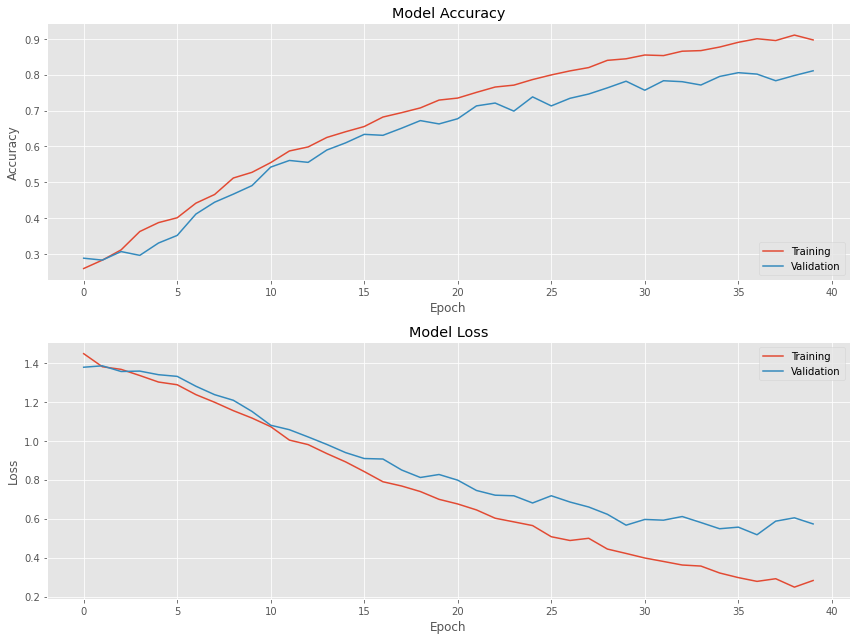

In [ ]:
def graph_training_history(history):
    plt.rcParams["figure.figsize"] = (12, 9) #Define the figure size of our graph taking in model called history

    plt.style.use('ggplot') #Defining the style of the plot

    plt.figure(1)

    plt.subplot(211) #Creating our axises for accuracy
    plt.plot(history.history['accuracy']) # Passing in our training accuracy
    plt.plot(history.history['val_accuracy']) #Passing in our validation accuracy
    plt.title('Model Accuracy') #Setting labels
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Training', 'Validation'], loc='lower right')

    plt.subplot(212) #Creating axises for loss
    plt.plot(history.history['loss']) #Passing in training loss
    plt.plot(history.history['val_loss']) #Passing in validation loss
    plt.title('Model Loss') #Labelling our graph
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Training', 'Validation'], loc='upper right')
    #We then display the graph
    plt.tight_layout()
    plt.show()

graph_training_history(history)
